In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-11 01:24:40.181110: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)
ds_path = "/drive0-storage/Gracia/dataset_2"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-11 01:24:43.796258: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 01:24:44.336741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 14112 files belonging to 3 classes.
Using 11290 files for training.
Found 14112 files belonging to 3 classes.
Using 2822 files for validation.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 245.63449
(184, 216, 3)


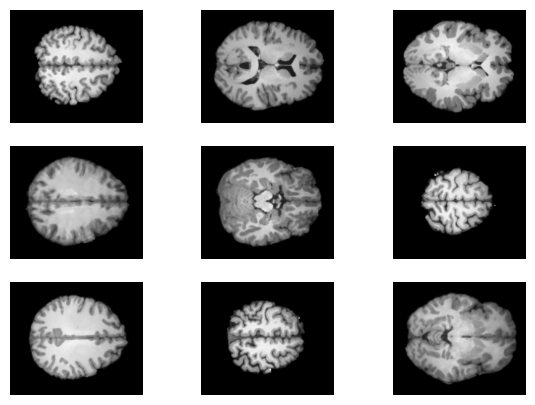

In [5]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [5]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
print(len(test_dataset))

45
44


## Model building

In [7]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [8]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [9]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn2_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [10]:
EPOCH = 25

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/25


2023-06-11 01:25:10.148770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-11 01:25:11.403247: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


353/353 [==============================] - 64s 170ms/step - loss: 1.0987 - accuracy: 0.3254 - val_loss: 1.0987 - val_accuracy: 0.3175
Epoch 2/25
353/353 [==============================] - 58s 165ms/step - loss: 1.0987 - accuracy: 0.3268 - val_loss: 1.0988 - val_accuracy: 0.3140
Epoch 3/25
353/353 [==============================] - 58s 164ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0987 - val_accuracy: 0.3168
Epoch 4/25
353/353 [==============================] - 58s 163ms/step - loss: 1.0986 - accuracy: 0.3355 - val_loss: 1.0987 - val_accuracy: 0.3239
Epoch 5/25
353/353 [==============================] - 58s 164ms/step - loss: 1.0987 - accuracy: 0.3331 - val_loss: 1.0986 - val_accuracy: 0.3246
Epoch 6/25
353/353 [==============================] - 58s 163ms/step - loss: 1.0966 - accuracy: 0.3501 - val_loss: 1.0929 - val_accuracy: 0.3536
Epoch 7/25
353/353 [==============================] - 58s 164ms/step - loss: 1.0764 - accuracy: 0.3992 - val_loss: 1.0638 - val_accuracy: 0.4

In [16]:
# model.save('./models/cnn2_25epoch.h5')

### Training evaluation

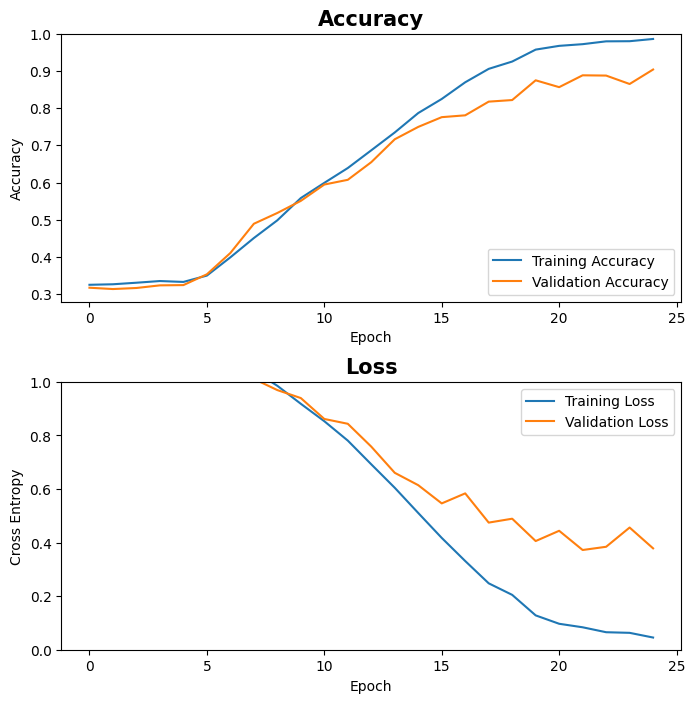

In [11]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [17]:
acc

[0.3254207372665405,
 0.3268378973007202,
 0.3310008943080902,
 0.33551815152168274,
 0.33312666416168213,
 0.35013285279273987,
 0.399202823638916,
 0.4510186016559601,
 0.49867138266563416,
 0.5584588050842285,
 0.5992913842201233,
 0.6391496658325195,
 0.6868025064468384,
 0.7347210049629211,
 0.7868910431861877,
 0.8247121572494507,
 0.8695305585861206,
 0.9055801630020142,
 0.9252435564994812,
 0.9573073387145996,
 0.9674047827720642,
 0.9719220399856567,
 0.9795393943786621,
 0.979893684387207,
 0.9859167337417603]

In [18]:
val_acc

[0.31753888726234436,
 0.3140028417110443,
 0.31683167815208435,
 0.3239038288593292,
 0.32461103796958923,
 0.35360679030418396,
 0.4108910858631134,
 0.4893918037414551,
 0.5183875560760498,
 0.5509193539619446,
 0.5947666168212891,
 0.607496440410614,
 0.6548797488212585,
 0.7164073586463928,
 0.7496463656425476,
 0.7758132815361023,
 0.7807638049125671,
 0.8175389170646667,
 0.8217821717262268,
 0.8748232126235962,
 0.8564356565475464,
 0.8882602453231812,
 0.8875530362129211,
 0.8649222254753113,
 0.9038189649581909]

In [19]:
loss

[1.0986950397491455,
 1.098651647567749,
 1.098638892173767,
 1.0986334085464478,
 1.0986595153808594,
 1.0965927839279175,
 1.0764027833938599,
 1.0407613515853882,
 0.98549884557724,
 0.9182495474815369,
 0.8531941175460815,
 0.7808281779289246,
 0.6922025680541992,
 0.6046029925346375,
 0.5105084776878357,
 0.41748467087745667,
 0.33115556836128235,
 0.24793563783168793,
 0.2048081010580063,
 0.12820357084274292,
 0.09686719626188278,
 0.0837755873799324,
 0.0653354749083519,
 0.06304267048835754,
 0.04551401361823082]

In [20]:
val_loss

[1.0987317562103271,
 1.0987634658813477,
 1.098666787147522,
 1.098680853843689,
 1.098637580871582,
 1.0928736925125122,
 1.0638034343719482,
 1.0110373497009277,
 0.9694244265556335,
 0.9396041035652161,
 0.8615925312042236,
 0.843613862991333,
 0.7582606673240662,
 0.6605084538459778,
 0.6143441200256348,
 0.546343982219696,
 0.5837626457214355,
 0.4746386408805847,
 0.48917123675346375,
 0.4057564437389374,
 0.444095641374588,
 0.37231653928756714,
 0.3843591809272766,
 0.4561752378940582,
 0.3785039186477661]

## Testing

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [13]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

44/44 [==============================] - 3s 56ms/step - loss: 0.4890 - accuracy: 0.8878


{'loss': 0.48896512389183044, 'accuracy': 0.8877840638160706}

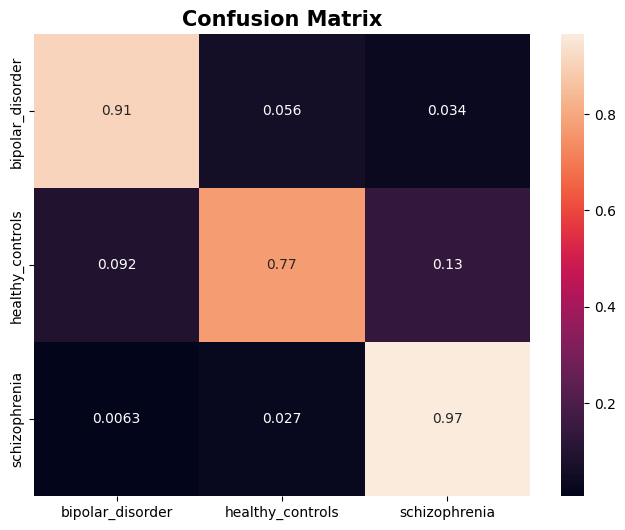

In [14]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN2_cm.png')
plt.show()

In [15]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.8877840638160706
Precision: 0.8857314763705482
Sensitivity: 0.8835227272727273
Specificity: 0.9415343843429143
